# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 3 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 3 members:
- Student 1: Camilla Ren #93534105
- Student 2: Dorothy Ger #26622993
- Student 3:


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

## Import Libraries:

In [24]:
# Here are some libraries you may need for this exercise, for your convenience

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    #plot_confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC


import joblib
from sklearn import tree
from sklearn.inspection import permutation_importance
import eli5

import warnings
warnings.filterwarnings("ignore")

# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 5 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the datasets and classsifiers by running the cells below:

In [25]:
# Note: these training and test sets do not correspond to the ones on the NIJ's website,
# they are our own partition

train_df = pd.read_csv("training_set.csv")
test_df = pd.read_csv("testing_set.csv")

In [26]:
# Creating training and test sets and separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [27]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
svm_model     = joblib.load("models_for_A3/NIJ_svm.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall, F1 score, and Area Under the Curve (AUC).**

### Question 1

can you provide definition and formula for accuracy, precision, recall and F1 score?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**Accuracy:** Accuracy is one metric for evaluating how often a classification model is correct overall. It's calculated as the ratio of correctly predicted instances to the total number of instances. The formula for accuracy is $\frac{TP+TN}{TP+FP+TN+FN} $. Accuracy values go between 0 and 1. Higher values indicate better performance of the classifier. However, it's worth noting that accuracy can be misleading when we have a class imbalance, as a model can achieve high accuracy by simply predicting the majority class. 

**Precision:** Precision refers to the quality of a positive prediction made by a classifier. It shows how often a model is correct when predicting the target class. It's calculated as the ratio of correctly predicted positive observations to the total predicted positives. The formula for precision is $\frac{TP}{TP+FP} $. Precision values go between 0 and 1. A higher precision indicates that more of the samples predicted as positive are actually positive. A model that produces no false positives has a precision of 1. However, it doesn't take into account the positive samples that were missed (FN). 

**Recall:** Recall refers to  the ability of a classifier to correctly identify all relevant instances. It's calculated as the ratio of correctly predicted positive observations to the actual number of positives. The formula for precision is $\frac{TP}{TP+FN} $. Recall values go between 0 and 1. A higher recall indicates that the classifier correctly identifies the majority of positive samples. A model that produces no false negatives has a recall of 1.0. However, this does not account for the accuracy of these positive predictions, which is measured by precision.

**F1 score:** F1 score combines precision and recall, which can also be used in hyperparameter optimization. It is particularly useful when classes are unevenly distributed. The F1 score is calculated as the harmonic mean of precision and recall, $2 \cdot \frac{precision\cdot recall}{precision + recall}$. Its values go between 0 and 1, where 1 represents perfect precision and recall, and 0 indicates neither precision nor recall. The higher the F1 score, the more balanced the classifier is in terms of FP and FN. Since the F1 score gives equal weight to precision and recall, it is a robust metric for situations where neither precision nor recall can be jeopardized.

### Question 2

For every classifier given, calculate and report accuracy, precision, recall, F1 score, and AUC on both training and test set. **For ease of visualization, summarize these results in one or two tables below this question.**

**Hints:** 
- Scikit-learn provides a lot of useful built-in functions to compute performance metrics. You can find them all in the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), under Classification Metrics.
- Some classifiers (*cough - SVM - cough cough*) take longer than others to make their predictions, so you may have to wait a few minutes for a cell to run. More than that, however, likely means something is wrong and needs to be fixed before continuing.

In [28]:
def calculate_metrics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_prob = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_auc = roc_auc_score(y_train, y_train_pred) 
    test_auc = roc_auc_score(y_test, y_test_pred)


    return {
        "train_accuracy": train_accuracy, "test_accuracy": test_accuracy,
        "train_precision": train_precision, "test_precision": test_precision,
        "train_recall": train_recall, "test_recall": test_recall,
        "train_f1": train_f1, "test_f1": test_f1,
        "train_auc": train_auc, "test_auc": test_auc,
    }

### LogReg Model:

In [29]:
logreg_metrics = calculate_metrics(logreg_model, X_train, y_train, X_test, y_test)
logreg_metrics

{'train_accuracy': 0.714609599646096,
 'test_accuracy': 0.7019739388466004,
 'train_precision': 0.7761194029850746,
 'test_precision': 0.7493970091654607,
 'train_recall': 0.7163214896446893,
 'test_recall': 0.7096847875742348,
 'train_f1': 0.7450224791265253,
 'test_f1': 0.7290004692632568,
 'train_auc': 0.7142734730573275,
 'test_auc': 0.7008251984120805}

### Random Forest Model:

In [30]:
rf_model_metrics = calculate_metrics(rf_model, X_train, y_train, X_test, y_test)
rf_model_metrics

{'train_accuracy': 0.9966268524662685,
 'test_accuracy': 0.7192620307057154,
 'train_precision': 0.9993319973279893,
 'test_precision': 0.7212620578778135,
 'train_recall': 0.9948698460953829,
 'test_recall': 0.819780721790772,
 'train_f1': 0.9970959295405856,
 'test_f1': 0.7673722471669874,
 'train_auc': 0.9969718375753442,
 'test_auc': 0.704287040409172}

### SVM Model:

In [31]:
svm_model_metrics = calculate_metrics(svm_model, X_train, y_train, X_test, y_test)
svm_model_metrics

{'train_accuracy': 0.7508847600088476,
 'test_accuracy': 0.7128112501612696,
 'train_precision': 0.7534304234363162,
 'test_precision': 0.7120614899487584,
 'train_recall': 0.850275508265248,
 'test_recall': 0.8252626770214709,
 'train_f1': 0.7989288105333632,
 'test_f1': 0.7644942869234024,
 'train_auc': 0.7313695614890675,
 'test_auc': 0.6960585546388113}

### Decision Tree Model:

EDITED ANSWER:

In [32]:
tree_metrics = calculate_metrics(tree_model, X_train, y_train, X_test, y_test)
tree_metrics

{'train_accuracy': 0.7386087148860871,
 'test_accuracy': 0.6978454392981551,
 'train_precision': 0.7618058690744921,
 'test_precision': 0.7135963071758288,
 'train_recall': 0.8015390461713852,
 'test_recall': 0.7768387391502969,
 'train_f1': 0.7811675385398825,
 'test_f1': 0.7438757655293088,
 'train_auc': 0.7262524550782832,
 'test_auc': 0.6860772409063076}

### XGBoost Model:

In [33]:
xgboost_model_matrix = calculate_metrics(xgboost_model, X_train, y_train, X_test, y_test)
xgboost_model_matrix

{'train_accuracy': 0.8735899137358991,
 'test_accuracy': 0.7359050445103857,
 'train_precision': 0.8672014260249554,
 'test_precision': 0.7372277630775493,
 'train_recall': 0.92437773133194,
 'test_recall': 0.8273184102329831,
 'train_f1': 0.8948772187988595,
 'test_f1': 0.7796792594984393,
 'train_auc': 0.8636178151234984,
 'test_auc': 0.7222865398333608}

### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [34]:
def plot_confusion_matrix(model, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0], cbar=False)
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[1], cbar=False)

    ax[0].set_title("Training Set Confusion Matrix")
    ax[0].set_ylabel("Actual")
    ax[0].set_xlabel("Predicted")

    ax[1].set_title("Test Set Confusion Matrix")
    ax[1].set_ylabel("Actual")
    ax[1].set_xlabel("Predicted")

    plt.tight_layout()
    plt.show()

### LogReg Model

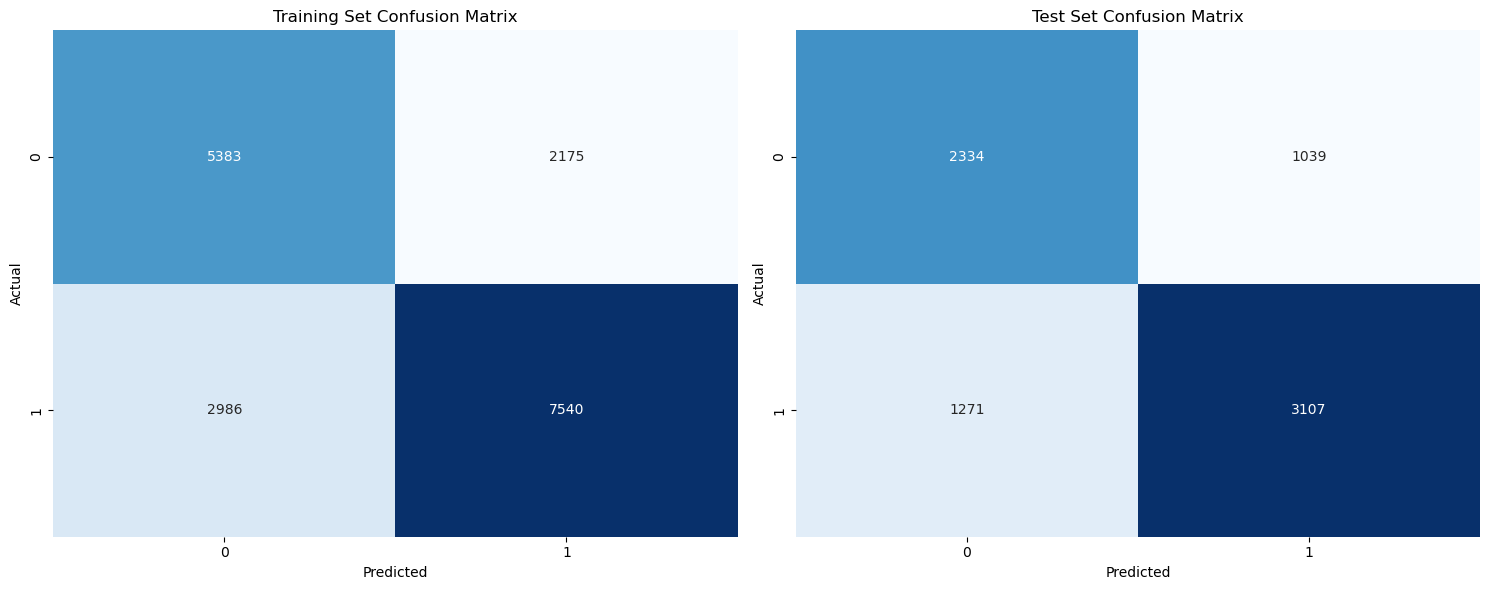

In [35]:
logreg_matrix = plot_confusion_matrix(logreg_model, X_train, y_train, X_test, y_test)
logreg_matrix

### Random Forest Model

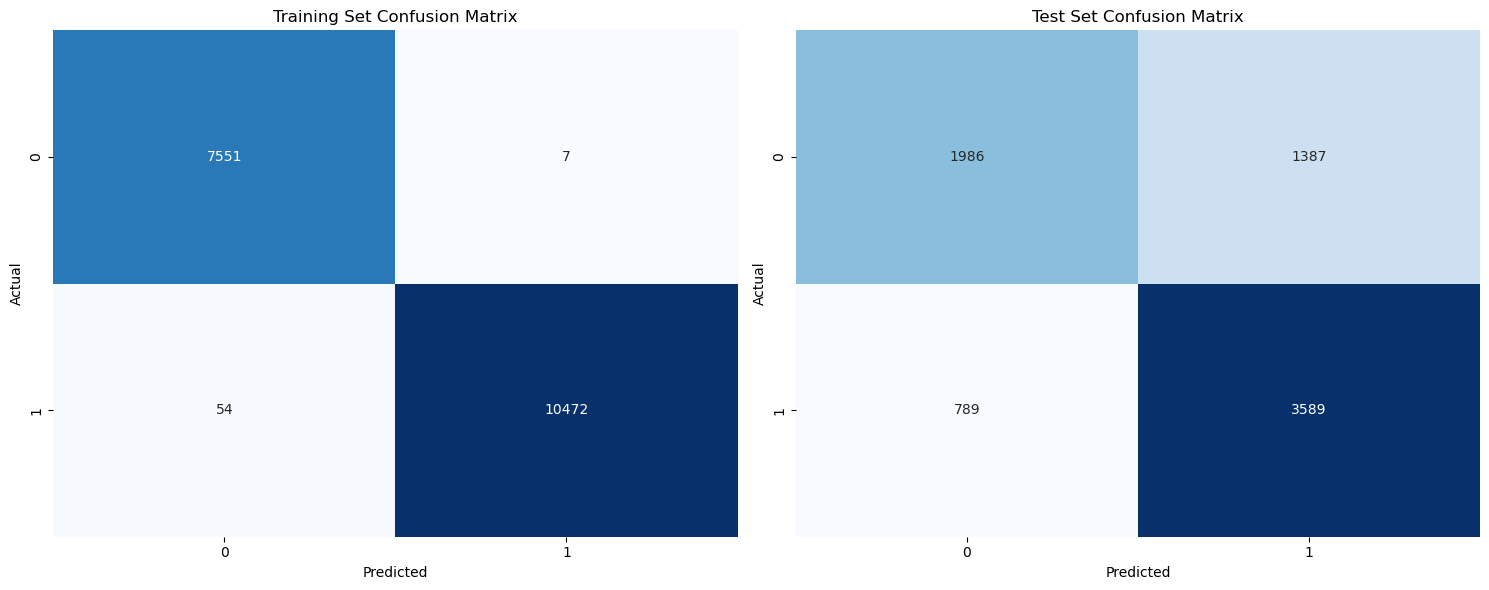

In [36]:
rf_model_matrix = plot_confusion_matrix(rf_model, X_train, y_train, X_test, y_test)
rf_model_matrix

### SVM Model

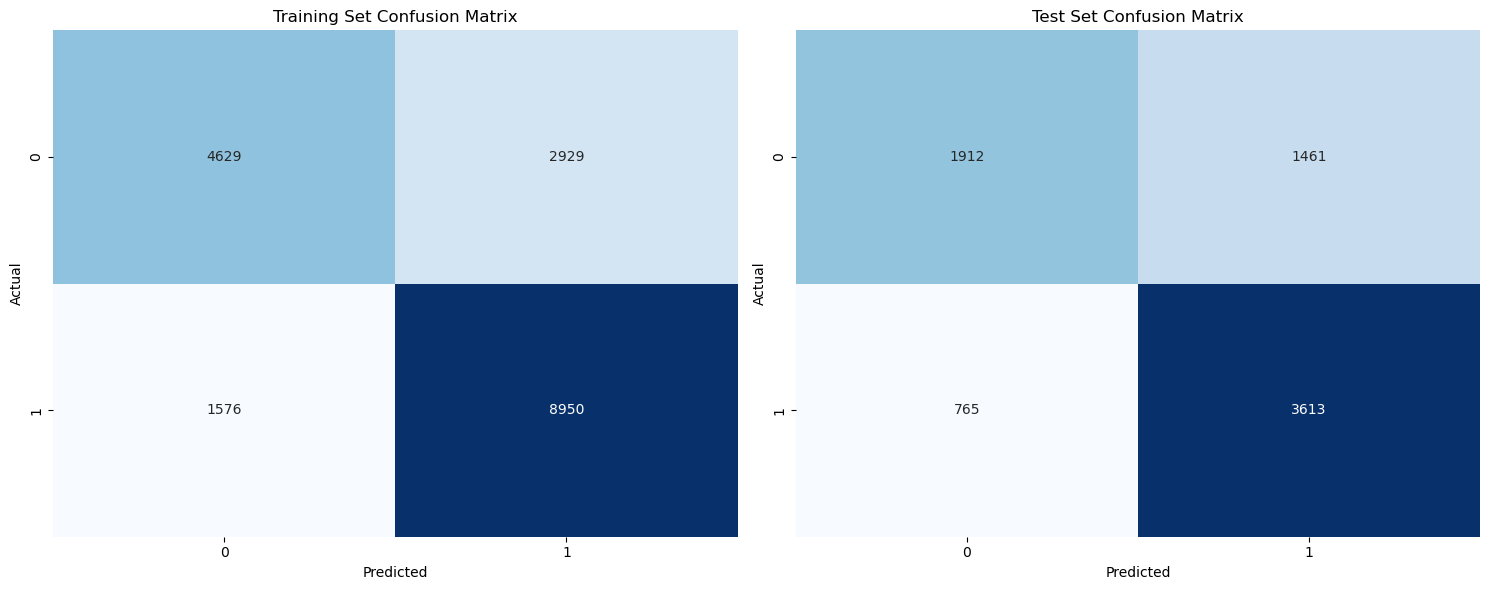

In [37]:
svm_model_matrix = plot_confusion_matrix(svm_model, X_train, y_train, X_test, y_test)
svm_model_matrix

### Decision Tree Model

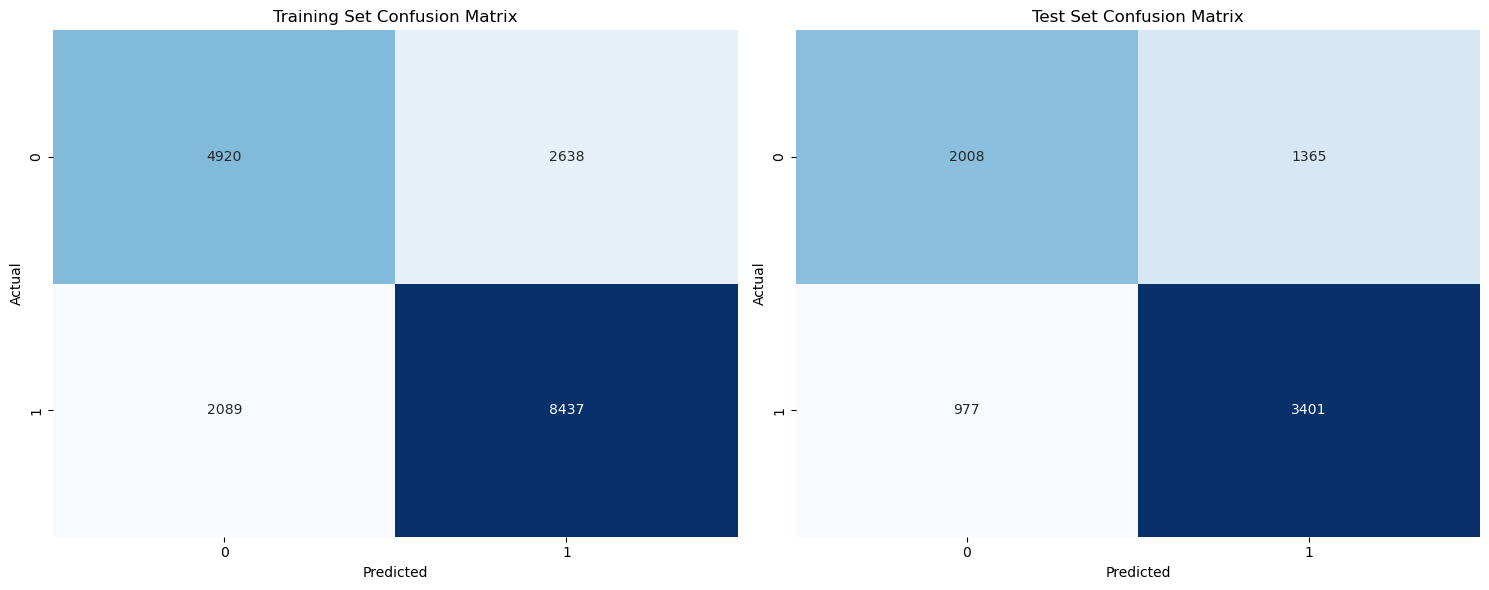

In [38]:
tree_model_matrix = plot_confusion_matrix(tree_model, X_train, y_train, X_test, y_test)
tree_model_matrix

### XGBoost Model

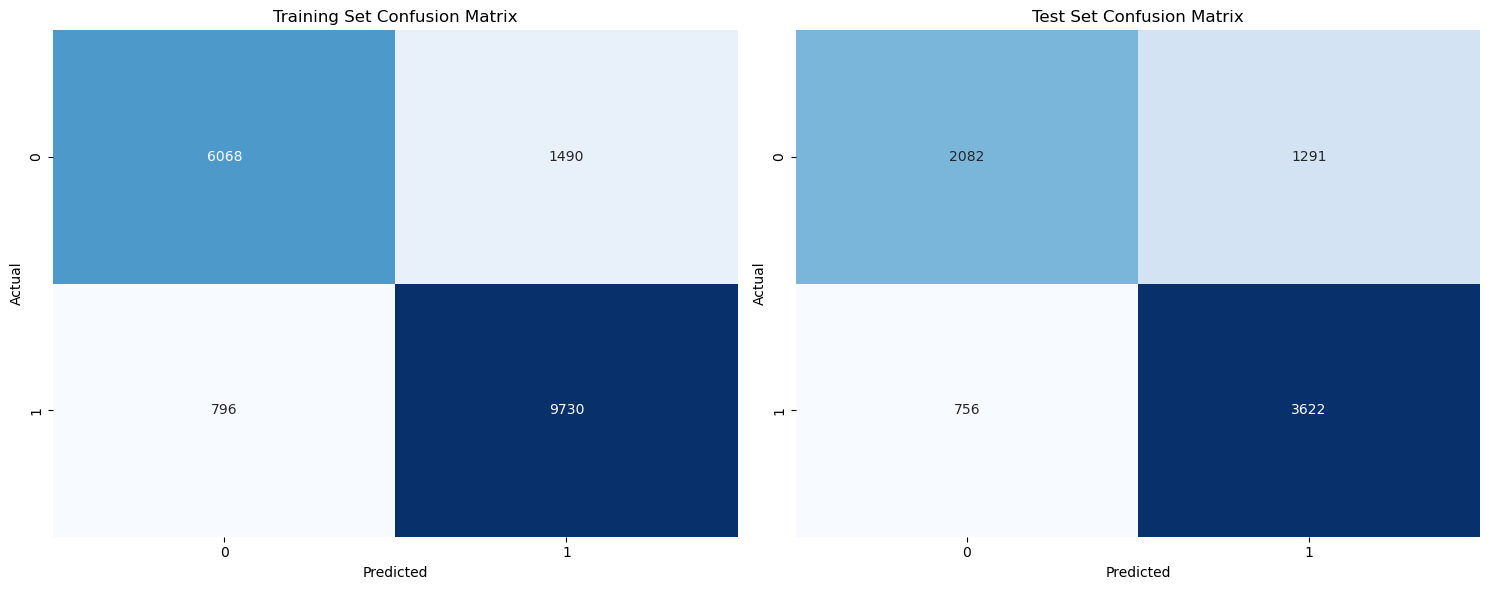

In [39]:
xgboost_model_matrix = plot_confusion_matrix(xgboost_model, X_train, y_train, X_test, y_test)
xgboost_model_matrix

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?

1. Based on the overall performance (different score methods we used in question 2), and confusion matrices we plotted, I would choose to deploy the XG Boost model. It not only has the highest test accuracy, precision, and AUC but also maintains high recall. The high AUC indicates it performs well in distinguishing between the classes. For the purpose of this task, we do not want to release the people with the risk to commit crimes again, and we would want to favor reporting the most number of positives for all the true positives at the tradeoff of reporting false positives, because not releasing a former criminal would do less societal harm than releasing a former criminal to commit another crime.
2. Based on the metrics we've calculated in question 2, I think the XGBoost model is the most "severe". This tendency of predicting the most amount of positives (classifies more people as at risk of committing another crime within 3 years) is reflected in the recall metric, The XGBoost model has the highest recall on the test set, suggesting it classifies the most individuals as being at risk of recidivism. 
3. Based on the metrics we calculated in question 2, I think the most cautious classifier is the Logistic Regression model. A cautious classifier would likely predict fewer positive instances (classifies less people as at risk of committing another crime within 3 years), trying to minimize the chance of falsely classifying someone as likely to commit a crime, which would be reflected in a low recall and high precision. The LogReg model has the highest test precision and lowest test recall among all the models.

# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for White and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper, which you will have to replicate, are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Finally, the paper also computes an **Average Distance from Reference** across all the above metrics. This helps us summarizing the fairness of a classifier in a single number. Compute the Average Distance from Reference for all the classifiers, knowing that the reference is 1 (i.e. a score of 1 indicates perfect fairness).

**Hints:**
- There are several ways to write Python code to easily compute the fairness metrics we want. If you have trouble starting, talk with a TA or with the instructor during our in-class work time or office hours to come up with a plan. 
- Instead of copy-pasting code, it is definitely a good idea to create one or more functions to compute the fairness metrics. Writing functions in Python is very easy! If you are new to it, start [here](https://www.geeksforgeeks.org/python-functions/) (stop before Arbitrary Keyword Arguments), and of course, come to us for more help!

In [40]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

white_train_data = train_data[train_data['Race'] == 'WHITE']
black_train_data = train_data[train_data['Race'] == 'BLACK']
white_test_data = test_data[test_data['Race'] == 'WHITE']
black_test_data = test_data[test_data['Race'] == 'BLACK']

X_train_white, y_train_white = white_train_data.drop(columns='Recidivism_Within_3years'), white_train_data['Recidivism_Within_3years']
X_train_black, y_train_black = black_train_data.drop(columns='Recidivism_Within_3years'), black_train_data['Recidivism_Within_3years']
X_test_white, y_test_white = white_test_data.drop(columns='Recidivism_Within_3years'), white_test_data['Recidivism_Within_3years']
X_test_black, y_test_black = black_test_data.drop(columns='Recidivism_Within_3years'), black_test_data['Recidivism_Within_3years']

EDITED ANSWER:

In [41]:
def compute_fairness_metrics(TP, FP, TN, FN, n_g, n):
    PPRD = (TP + FP) / n 
    PPGRD = (TP + FP) / n_g 
    FDRD = FP / (TP + FP) if TP + FP != 0 else 0
    FPRD = FP / (TN + FP) if TN + FP != 0 else 0
    FORD = FN / (TN + FN) if TN + FN != 0 else 0
    FNRD = FN / (TP + FN) if TP + FN != 0 else 0

    results = {
        'PPRD': PPRD,
        'PPGRD': PPGRD,
        'FDRD': FDRD,
        'FPRD': FPRD,
        'FORD': FORD,
        'FNRD': FNRD
    }
    
    return results

In [95]:
def model_fairness(model, X_test_white, y_test_white, X_test_black, y_test_black, test_data):
    y_pred_white = model.predict(X_test_white)
    y_pred_black = model.predict(X_test_black)

    TN_white, FP_white, FN_white, TP_white = confusion_matrix(y_test_white, y_pred_white).ravel()
    TN_black, FP_black, FN_black, TP_black = confusion_matrix(y_test_black, y_pred_black).ravel()

    n_white = len(X_test_white)
    n_black = len(X_test_black)
    n = len(test_data)

    metrics_white = compute_fairness_metrics(TP_white, FP_white, TN_white, FN_white, n_white, n)
    metrics_black = compute_fairness_metrics(TP_black, FP_black, TN_black, FN_black, n_black, n)

    ratios = {}
    for metric in metrics_white:
        white_metric = metrics_white[metric]
        black_metric = metrics_black[metric]
        if black_metric > 0:
            ratios[f"ratio_{metric}"] =  black_metric / white_metric 
        else:
            ratios[f"ratio_{metric}"] = float('inf') 

    ADR = sum(abs(ratio - 1) for ratio in ratios.values()) / len(ratios)

    #print('For White group:')
    #for key, value in metrics_white.items():
     #   print(f"{key} is {value:.4f}")
    #print('For Black group:')
    #for key, value in metrics_black.items():
     #   print(f"{key} is {value:.4f}")
    #print('Comparison between White and Black groups:')
    for key, value in ratios.items():
        print(f"{key} is {value:}")
    print(f"\nADR is {ADR:}")

    return metrics_white, metrics_black, ratios, ADR

In [96]:
# For LogReg Model
metrics_white, metrics_black, ratios, ADR = model_fairness(logreg_model, X_test_white, y_test_white, X_test_black, y_test_black, test_data)

ratio_PPRD is 1.4693269803454436
ratio_PPGRD is 1.0711042988554338
ratio_FDRD is 1.027451245327208
ratio_FPRD is 1.1661602199425773
ratio_FORD is 1.0913461538461537
ratio_FNRD is 0.9649373881932021

ADR is 0.1434085850206024


In [97]:
# For Random Forest Model
metrics_white, metrics_black, ratios, ADR  = model_fairness(rf_model, X_test_white, y_test_white, X_test_black, y_test_black, test_data)

ratio_PPRD is 1.4929859719438878
ratio_PPGRD is 1.0883511390391758
ratio_FDRD is 1.022388479358443
ratio_FPRD is 1.1790988631697437
ratio_FORD is 1.0560758824231877
ratio_FNRD is 0.8696349301000462

ADR is 0.16154423430573198


In [98]:
# For SVM Model
metrics_white, metrics_black, ratios, ADR  = model_fairness(svm_model, X_test_white, y_test_white, X_test_black, y_test_black, test_data)

ratio_PPRD is 1.4995073891625614
ratio_PPGRD is 1.0931050965387579
ratio_FDRD is 1.054527704387476
ratio_FPRD is 1.221476597301267
ratio_FORD is 1.1101729827350164
ratio_FNRD is 0.8992921134475237

ADR is 0.17991627611292582


In [99]:
# For Decision Tree Model
metrics_white, metrics_black, ratios, ADR  = model_fairness(tree_model, X_test_white, y_test_white, X_test_black, y_test_black, test_data)

ratio_PPRD is 1.505783385909569
ratio_PPGRD is 1.0976801483721774
ratio_FDRD is 1.0430593693778998
ratio_FPRD is 1.2132493743153094
ratio_FORD is 1.0867725617773714
ratio_FNRD is 0.8976453715302362

ADR is 0.17481657803701514


In [100]:
# For XGBoost Model
metrics_white, metrics_black, ratios, ADR  = model_fairness(xgboost_model, X_test_white, y_test_white, X_test_black, y_test_black, test_data)

ratio_PPRD is 1.4345887016848367
ratio_PPGRD is 1.0457809228431956
ratio_FDRD is 1.0008785479193143
ratio_FPRD is 1.1091424662152114
ratio_FORD is 1.132485577313724
ratio_FNRD is 1.0026356589147285

ADR is 0.12091864581516838


### Question 6

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model exhibits the least amount of bias? 
- Which one is the worse?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? 

1. A model is considered less biased if its metrics are closer to 1, indicating parity between White and Black groups. By comparing the ratios for different models, we can see that XG Boost model tends to have ratios closer to 1 in most metrics, indicating that it has the least disparity in terms of fairness across races. It has the highest scores in PPRD, PPGRD, FDRD, FPRD, and FNRD. The ADR, which can be seen as an overall measure of disparity, is also competitive for the XG Boost model (it is only 0.01 higher that LogReg model which is the closest to 1). Therefore, based on these metrics, the XG Boost model has the least overall bias of the models evaluated.

2. Each model displays varying levels and types of bias. The Decision Tree model displays a higher bias towards positive predictions (PPRD and PPGRD), whereas the SVM model demonstrates significant bias towards false positives and omissions (FDRD, FPRD and FORD), and the Random Forest model is more biased towards false negatives (FNRD). However, based on the overall disparity ratio (ADR), it is evident that the SVM model exhibits the highest level of bias in various areas such as false positives and omissions.

3. FPRD and FNRD should be the most important. For FPRD, a high FP rate for a particular group can lead to individuals being unfairly labelled as likely to recidivate, which can have a potentially negative impact on them. This can lead to unjust consequences such as longer parole periods, more frequent checkups, and even unnecessary social distrust. In this case, if FPRD is consistently higher for a racial group, it suggests racial bias in false charges against potential recidivists. FNRD is also important because a high FN rate means that individuals who are likely to recidivate are not identified, thus posing a potential risk to society. These individuals may not be receptive to interventions that could prevent future crime. Differences in FN rates between race groups suggest that one group is more likely to escape detection than the other.
   
   PPRD and PPGRD could be taken less into consideration because they focus more on the distribution of positive predictions rather than the accuracy of those predictions. While these metrics tell us about potential disparate impact, they don't directly inform us about the model's mistakes. Especially in cases where wrong predictions can have serious real-world consequences, we should focus on the model's inaccuracy rather than the distribution of its predictions.

4. Given the importance of fairness, particularly in predicting criminal behavior, the ideal approach involves selecting a model with metrics that are closest to 1 across all categories. The XG Boost Model is most noteworthy because of its exceptional PPRD and PPGRD ratios and almost perfect FNRD ratios, indicating minimal inequality in critical areas. In spite of having a slightly higher FPRD, this model offers the best overall balance between treating both ethnic groups equally in accordance with the given criteria.

# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 7

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [48]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [49]:
coeff_df_sorted.head(10)

,Coefficient
pipeline-2__Gang_Affiliated_True,0.777355
pipeline-2__Age_at_Release_18-22,0.769491
pipeline-2__Delinquency_Reports_1,0.635838
pipeline-2__Age_at_Release_23-27,0.488772
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.473405
pipeline-2__Gender_M,0.458260
passthrough__Prior_Revocations_Parole,0.362398
passthrough__Condition_MH_SA,0.359117
pipeline-1__Jobs_Per_Year,0.312944
pipeline-2__Prison_Years_Less than 1 year,0.307459


In [50]:
coeff_df_sorted.tail(10)

,Coefficient
pipeline-2__Delinquency_Reports_3,-0.205489
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.216048
pipeline-2__Age_at_Release_38-42,-0.235466
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.249548
pipeline-2__Age_at_Release_43-47,-0.350821
pipeline-2__Program_Attendances_10 or more,-0.385809
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.501982
pipeline-2__Delinquency_Reports_4 or more,-0.507616
pipeline-1__Percent_Days_Employed,-0.663686
pipeline-2__Age_at_Release_48 or older,-0.752269


Based on the output from the cells above:
1. Features with increasing the likelihood of recidivism include:
    1. Gang Affiliation (True): Individuals affiliated with gangs are significantly more likely to be predicted as recidivists. This could be due to gang cultures often being associated with ongoing criminal activity.
    2. Age at Release (18-22 & 23-27): Younger individuals, particularly those in the 18-22 and 23-27 age brackets, are more likely to re-offend. This might be influenced by a lack of maturity, impulse control, or stable life structures (like steady employment).
    3. Delinquency Reports (1): Having one delinquency report seems to significantly increase the likelihood of recidivism, potentially indicating a pattern of behavior.
    4. Prior Arrest Episodes (Felony, 0): Surprisingly, I can't think of any obvious reason this is the case.
    5. Gender (Male): Being male is associated with a higher risk of recidivism. This might reflect social, economic, or cultural factors that differ by gender.

2. Features decreasing the likelihood of recidivism include:
    1. Age at Release (48 or older & 43-47): Older individuals are less likely to re-offend, potentially due to greater life stability or decreased involvement in activities overall.
    2. Percent Days Employed: Higher employment is associated with a lower risk of recidivism, likely because steady employment may provide both a stable income and a stable routine.
    3. Delinquency Reports (4 or more): Contrary to having one report, having four or more delinquency reports decreases the likelihood of recidivism.
    4. Prior Arrest Episodes (Felony, 1): Having one prior felony arrest decreases the likelihood of recidivism, contrary to having zero.

3. Potential Unfair Influences:
    1. Gang Affiliation and Age at Release: These factors could be influenced by societal biases. Younger individuals and those affiliated with gangs might experience selective enforcement from the jurisdiction (I'm not sure about this either), increasing their likelihood of being classified as high-risk by the model.
    2. Gender: If the dataset contains biases regarding gender (men are more likely to be arrested for voilence related crimes ?), this might be related with societal biases and could unfairly influence the decision.


The larger social and institutional context might be the underlying cause for the influences when analyzing these coefficients. Some characteristics may represent socio-economic conditions or biases, which could result in discriminatory predictions. Also correlation does not equal causation, and these links may not be direct causes but rather proxies of other omitted factors.

### Question 8

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [51]:
hard_sample = X_test[106:107]
X_test[106:107]

,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
106,5645,5788,F,WHITE,48 or older,3,NaN,6.0,High,At least some college,...,NaN,NaN,NaN,0.596215,2.0,False,False,False,False,0


In [52]:
y_test[106:107]

106    False
Name: Recidivism_Within_3years, dtype: bool

If you look at the ground truth for this sample (try `y_test[106:107]`) you will see that this person has not, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer and comment below:

In [53]:
logreg_model.predict(hard_sample)

array([False])

Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

In [54]:
transformed_sample = logreg_model.named_steps['columntransformer'].transform(X_test.iloc[106:107])

transformed_sample_values = transformed_sample.flatten()

weighted_values = transformed_sample_values * coeffs

most_positive_feature_index = np.argmax(weighted_values)
most_negative_feature_index = np.argmin(weighted_values)

most_positive_feature = feature_names[most_positive_feature_index]
most_negative_feature = feature_names[most_negative_feature_index]

print(f"Most Positive Contribution: {most_positive_feature}")
print(f"Most Negative Contribution: {most_negative_feature}")

Most Positive Contribution: pipeline-1__Jobs_Per_Year
Most Negative Contribution: pipeline-2__Age_at_Release_48 or older


The feature 'pipeline-1__Jobs_Per_Year' has contributed the most to the final prediction. The number of jobs per year had a strong positive influence on the logistic regression model's output. According to the logistic regression model, individuals with more jobs per year are more likely to commit a new crime within the specified time frame. 

The feature 'pipeline-2__Age_at_Release_48 or older' has the greatest negative impact on the final prediction. This suggests that those who are 48 or older at the time of release are less likely to be predicted by the model. This implies that being aged 48 or older at the time of release decreases the predicted risk of recidivism.

### Question 9
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

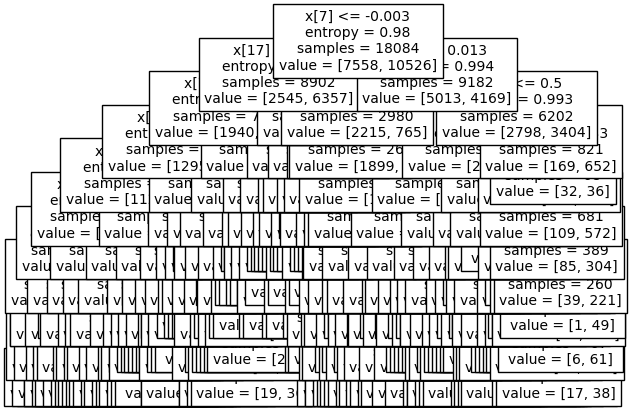

<Figure size 1000x600 with 0 Axes>

In [55]:
tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

Since the nodes are overlapped, it is very difficult to determine. I can only identify the feature used in the root node x[7] as the most influential feature in the decision tree model because it is the first criterion used to split the data. 

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [56]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

|--- pipeline-1__Percent_Days_Employed <= -0.00
|   |--- pipeline-2__Age_at_Release_48 or older <= 0.50
|   |   |--- pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0 <= 0.50
|   |   |   |--- pipeline-2__Gang_Affiliated_True <= 0.50
|   |   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Misd_6 or more <= 0.50
|   |   |   |   |   |--- pipeline-1__Supervision_Risk_Score_First <= 0.20
|   |   |   |   |   |   |--- pipeline-1__Percent_Days_Employed <= -1.15
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M <= 0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M >  0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Conviction_Episodes_Prop_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Arre

No, it's still very hard to identify since the tree is too large and too complex.

When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

<Axes: >

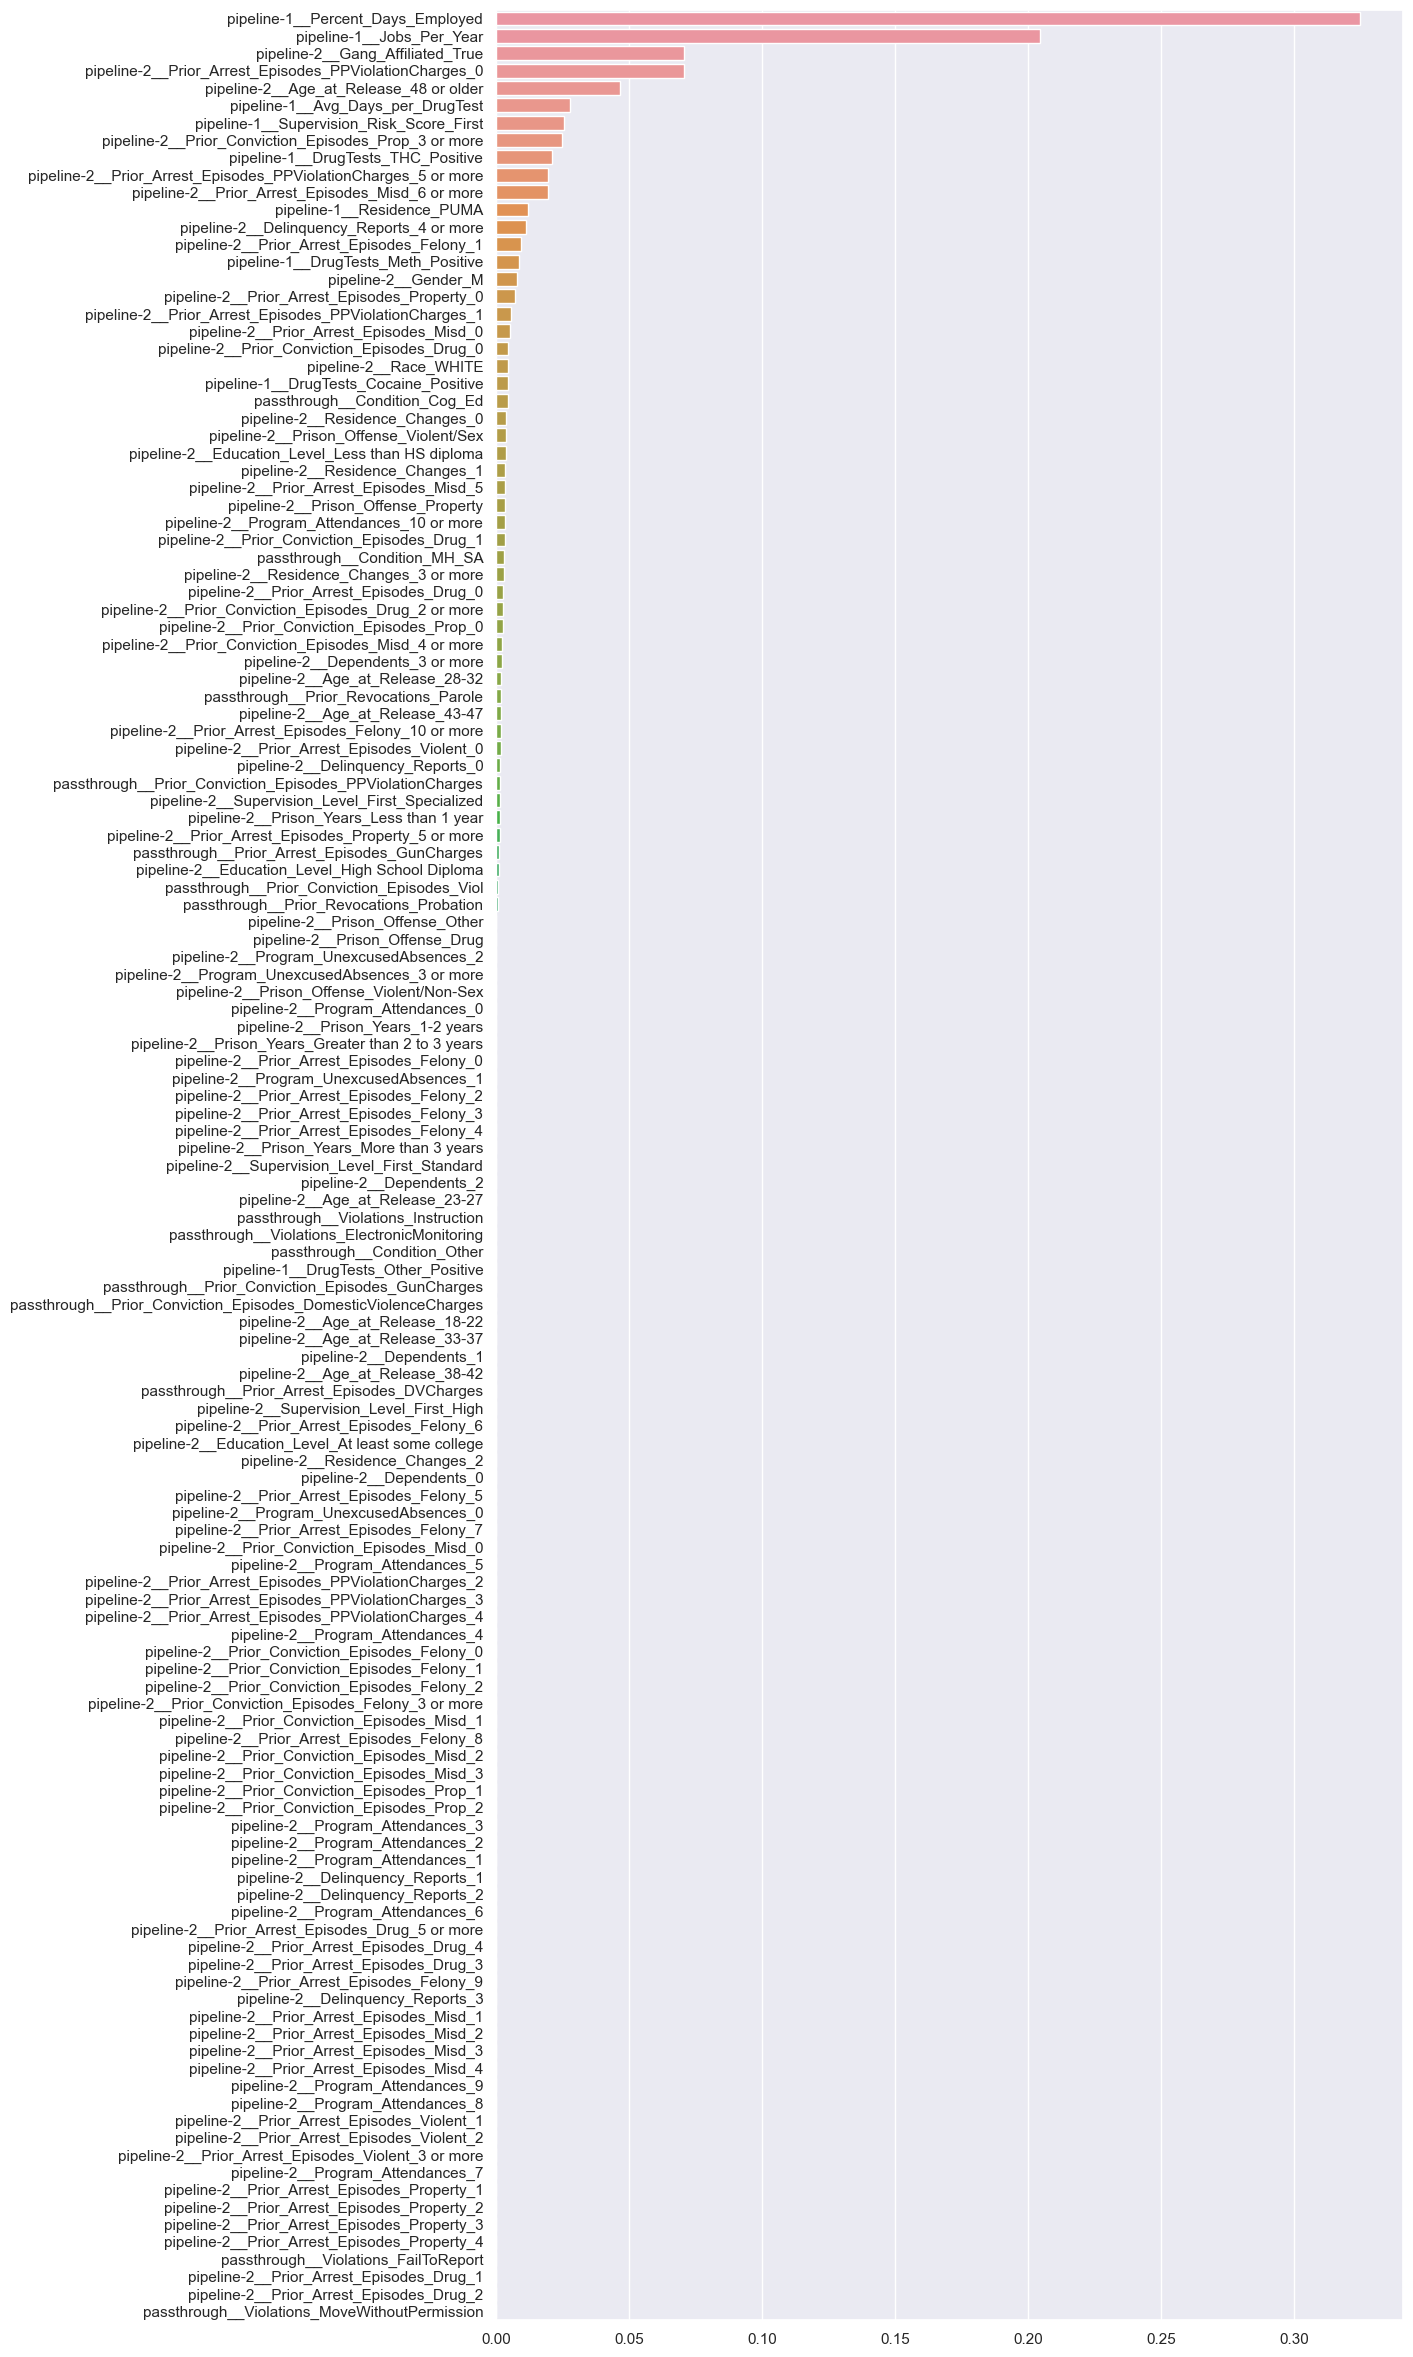

In [57]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

From both the table and bar plot, we can see that 'pipeline-1__Percent_Days_Employed' feature holds significant importance in both models. In the logistic regression model, it has a high negative coefficient, suggesting a decrease in the likelihood of committing a new crime with an increase in employment days, which makes intuitive sense. While in the decision tree model, it's also the most crucial feature. 'Pipeline-2__Age_at_Release_48 or older' is important in both models, however, it has a negative coefficient in the logistic regression model. Features like 'pipeline-2__Age_at_Release_48 or older,' 'pipeline-1__Jobs_Per_Year,' and 'pipeline-2__Delinquency_Reports_4 or more' are common. This consistency across different models can indicate these features are genuinely influential in predicting the outcome. While some features appear in both models, their importance might differ. For instance, in the logistic regression, 'pipeline-2__Age_at_Release_48 or older' has a strong negative coefficient, suggesting a significant decrease in the likelihood of committing a new crime as this feature increases. This might not be as prominent in the tree model. Some features like 'pipeline-2__Age_at_Release_18-22' and 'pipeline-2__Delinquency_Reports_1' hold significant importance in the logistic regression model but are not among the top features in the decision tree model. Conversely, features like 'prior_arrest_episodes_misd' and 'prior_arrest_episodes_felony' are critical in the decision tree model but aren't the top features in the logistic regression model.

Compared with the paper's results, the decision tree model aligns closely with the original paper's model, it supports the validity of that model's predictions in this context. While many of the features remain important in both the model and the original paper results, there are noticeable differences in their rankings and significance. 'Percent_Days_Employed' remains the most important feature in both the provided image and the original paper results. Its dominance in determining outcomes is consistent in both models. The importance of the 'Jobs per year' feature appears to be consistent across the model and the original paper results, highlighting the importance of employment frequency. While 'Gang_Affiliated_True' feature appears significantly in both visuals, its ranking appears to differ. It appears to be more important in the original paper results than in the decision tree model. The 'Age_at_Release_48 or older' feature is emphasized similarly in both instances, suggesting that the age at which someone is released plays a crucial role in the model's decisions.

Feature importance from tree models like the decision tree model gives  an understanding of which features are most influential in making predictions. However, it doesn't tell us how a feature affects the target variable (the direction of the relationship). One of the significant advantages of logistic regression model is the interpretability of its coefficients. The coefficients in logistic regression  quantifies the strength and direction (positive or negative) of the relationship between the predictor and the response variable. Feature importance from decision tree models, on the other hand, gives a ranking of the predictors in terms of their impact on the model's prediction. It doesn't tell us about the direction of the relationship (whether it's positive or negative).

### Question 10

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [58]:
def evaluate_model(model, sample, true_label, model_name):
    predicted_label = model.predict(sample)
    
    print(f"For {model_name} Model:")
    if predicted_label[0] == true_label:
        print("Prediction is correct!")
    else:
        print("Prediction is incorrect.")
    print("")

In [59]:
evaluate_model(logreg_model, hard_sample, y_test[106], "Logistic Regression")
evaluate_model(rf_model, hard_sample, y_test[106], "Random Forest")
evaluate_model(svm_model, hard_sample, y_test[106], "SVM")
evaluate_model(tree_model, hard_sample, y_test[106], "Decision Tree")
evaluate_model(xgboost_model, hard_sample, y_test[106], "XGBoost")

For Logistic Regression Model:
Prediction is correct!

For Random Forest Model:
Prediction is incorrect.

For SVM Model:
Prediction is correct!

For Decision Tree Model:
Prediction is incorrect.

For XGBoost Model:
Prediction is incorrect.



We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the 3 non-inherently interpretable models included in this exercise: the Random Forest, SVM, and XGBoost.

#### Surrogate for Random Forest Model

In [60]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set

rf_train_predictions = rf_model.predict(X_train)
surrogate_model_rf.fit(X_train, rf_train_predictions)

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model

feature_names = np.array(surrogate_model_rf.named_steps['columntransformer'].get_feature_names_out())
coeffs = surrogate_model_rf.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

print("Random Forest Surrogate Top 10 Features:", coeff_df_sorted.head(10))
print("Random Forest Surrogate Bottom 10 Features:", coeff_df_sorted.tail(10))


Random Forest Surrogate Top 10 Features:                                               Coefficient
pipeline-2__Age_at_Release_18-22                 0.796636
pipeline-2__Gang_Affiliated_True                 0.790565
pipeline-2__Delinquency_Reports_1                0.650981
pipeline-2__Prior_Arrest_Episodes_Felony_0       0.489534
pipeline-2__Age_at_Release_23-27                 0.488824
pipeline-2__Gender_M                             0.446960
passthrough__Prior_Revocations_Parole            0.370422
passthrough__Condition_MH_SA                     0.357176
pipeline-1__Jobs_Per_Year                        0.319845
passthrough__Violations_ElectronicMonitoring     0.319349
Random Forest Surrogate Bottom 10 Features:                                                     Coefficient
pipeline-2__Delinquency_Reports_3                     -0.204958
pipeline-2__Prior_Arrest_Episodes_PPViolationCh...    -0.230000
pipeline-2__Age_at_Release_38-42                      -0.238056
pipeline-2__Prior_Arr

Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

1. The Random Forest model is an ensemble of decision trees and makes its predictions based on the voting or averaging of these trees. The features with high coefficients in the surrogate model are likely to be frequently used and carry significant weight in the Random Forest's decision trees.
2. The Age at Release (18-22 & 23-27) feature have high positive coefficients, suggesting that younger individuals are more likely to be classified as recidivists.Gang Affiliation also has a strong positive influence on the prediction, implying that individuals with gang ties are more likely to re-offend. and other features like Delinquency Reports, Prior Arrest Episodes (Felony),Gender (Male), Prior Revocations (Parole), Mental Health/Substance Abuse Conditions, Jobs Per Year, and Violations (Electronic Monitoring) all have a positive influence towards predicting positively (which means the individual would re-offend) on the predictions.
3.  These features (like age, gang affiliation, prior offenses) are also highlighted as important in other models, there's consistency in what characteristics are considered high risk, which adds confidence. 

**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [61]:
def get_num_correct(y, y_pred, t=0.5):
    y_correct = np.array([0.0 if p < t else 1.0 for p in y_pred])
    return sum([1.0 for p, p_pred in zip(y, y_correct) if p == p_pred])

def count_rsquare(y, y_pred, t=0.5):
    n = float(len(y))
    num_correct = get_num_correct(y, y_pred, t)
    return num_correct / n

rf_train_predictions = rf_model.predict(X_train)

surrogate_train_predictions = surrogate_model_rf.predict(X_train)

count_r2_score = count_rsquare(rf_train_predictions, surrogate_train_predictions)
count_r2_score

0.7180380446803805

Now, repeat the analysis through surrogate model for SVM and XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for SVM Model

In [62]:
surrogate_model_svm = joblib.load("models_for_A3/NIJ_logreg.joblib")
svm_train_predictions = svm_model.predict(X_train)
surrogate_model_svm.fit(X_train, svm_train_predictions)

feature_names_svm = np.array(surrogate_model_svm.named_steps['columntransformer'].get_feature_names_out())
coeffs = surrogate_model_rf.named_steps["logisticregression"].coef_.flatten()
coeff_df_svm = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted_svm = coeff_df_svm.sort_values(by="Coefficient", ascending=False)


print("SVM Surrogate Top 10 Features:", coeff_df_sorted_svm.head(10))
print("SVM Surrogate Bottom 10 Features:", coeff_df_sorted_svm.tail(10))


SVM Surrogate Top 10 Features:                                               Coefficient
pipeline-2__Age_at_Release_18-22                 0.796636
pipeline-2__Gang_Affiliated_True                 0.790565
pipeline-2__Delinquency_Reports_1                0.650981
pipeline-2__Prior_Arrest_Episodes_Felony_0       0.489534
pipeline-2__Age_at_Release_23-27                 0.488824
pipeline-2__Gender_M                             0.446960
passthrough__Prior_Revocations_Parole            0.370422
passthrough__Condition_MH_SA                     0.357176
pipeline-1__Jobs_Per_Year                        0.319845
passthrough__Violations_ElectronicMonitoring     0.319349
SVM Surrogate Bottom 10 Features:                                                     Coefficient
pipeline-2__Delinquency_Reports_3                     -0.204958
pipeline-2__Prior_Arrest_Episodes_PPViolationCh...    -0.230000
pipeline-2__Age_at_Release_38-42                      -0.238056
pipeline-2__Prior_Arrest_Episodes_Felony_

#### Surrogate for XGBoost Model

In [63]:
surrogate_model_xgb = joblib.load("models_for_A3/NIJ_logreg.joblib")
xgb_train_predictions = xgboost_model.predict(X_train)
surrogate_model_xgb.fit(X_train, xgb_train_predictions)

feature_names_xgb = np.array(surrogate_model_xgb.named_steps['columntransformer'].get_feature_names_out())
coeffs = surrogate_model_xgb.named_steps["logisticregression"].coef_.flatten()
coeff_df_xgb = pd.DataFrame(coeffs, index=feature_names_xgb, columns=["Coefficient"])
coeff_df_sorted_xgb = coeff_df_xgb.sort_values(by="Coefficient", ascending=False)

print("XGBoost Surrogate Top 10 Features:", coeff_df_sorted_xgb.head(10))
print("XGBoost Surrogate Bottom 10 Features:", coeff_df_sorted_xgb.tail(10))


XGBoost Surrogate Top 10 Features:                                                     Coefficient
pipeline-2__Age_at_Release_18-22                       1.344978
pipeline-2__Gang_Affiliated_True                       1.322722
pipeline-2__Gender_M                                   0.939579
pipeline-2__Delinquency_Reports_1                      0.853040
pipeline-2__Age_at_Release_23-27                       0.767391
pipeline-2__Prior_Arrest_Episodes_Felony_0             0.668436
passthrough__Condition_MH_SA                           0.643236
pipeline-2__Prior_Arrest_Episodes_Felony_10 or ...     0.606695
pipeline-2__Prison_Years_Less than 1 year              0.591937
passthrough__Violations_ElectronicMonitoring           0.589146
XGBoost Surrogate Bottom 10 Features:                                                     Coefficient
pipeline-2__Prison_Years_Greater than 2 to 3 years    -0.373178
pipeline-2__Prior_Arrest_Episodes_Felony_2            -0.378917
pipeline-2__Age_at_Release_38-4

1. What seem to be the most important features?

From the "SVM Surrogate Top 10 Features" list, some of the most important features impacting the recidivism are:

pipeline-2__Age_at_Release_18-22, pipeline-2__Age_at_Release_23-27: Individuals aged between 18-22 and 23-27 are more likely tocommitting a new crime.
pipeline-2__Gang_Affiliated_True: Being affiliated with a gang significantly impacts the outcome.
pipeline-2__Delinquency_Reports_1: Having one delinquency report is influential.
Prior arrest episodes for a felony: Especially if there are none.
pipeline-2__Gender_M: Being male (M).
Prior revocations related to parole, mental health or substance abuse conditions, jobs per year, and violations related to electronic monitoring also show significance.

For the XGBoost surrogate model:

Top Important Features: pipeline-2__Age_at_Release_18-22 , pipeline-2__Gang_Affiliated_True, pipeline-2__Gender_M, pipeline-2__Delinquency_Reports_1 , and pipeline-2__Age_at_Release_23-277 are among the most positively weighted features, suggesting they play a critical role in the model's prediction.

Since both models have pipeline-2__Age_at_Release_18-22, pipeline-2__Age_at_Release_23-27,pipeline-2__Gang_Affiliated_True, pipeline-2__Delinquency_Reports_1, pipeline-2__Gender_M in commons, these seem to be the most important features.

2. There's a consistency in the importance of certain features across models such as 'pipeline-1__Percent_Days_Employed', 'pipeline-2__Age_at_Release_48 or older',  'pipeline-2__Delinquency_Reports_4 or more' etc, suggesting that these features are pivotal in predicting the outcome. Such consistency can provide confidence in these features being genuine indicators. While some features consistently appear as important, the degree of their importance or the direction of their influence might differ. This suggests that different models might capture different nuances of the data.

    Some features are weighted differently across models. For instance, while 'pipeline-2__Age_at_Release_18-22' and 'pipeline-2__Delinquency_Reports_1' are highly influential in the logistic regression model, they might not be as prominent in the decision tree or the SVM surrogate. Conversely, features like 'prior_arrest_episodes_misd' and 'prior_arrest_episodes_felony' are very significant in the decision tree model but aren't among the top features in the logistic regression model.

3. How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?

In [64]:
svm_train_predictions = svm_model.predict(X_train)

surrogate_train_predictions = surrogate_model_svm.predict(X_train)

count_r2_score_svm = count_rsquare(svm_train_predictions, surrogate_train_predictions)
count_r2_score_svm

0.9423247069232471

In [65]:
xgboost_train_predictions = xgboost_model.predict(X_train)

surrogate_train_predictions = surrogate_model_xgb.predict(X_train)

count_r2_score_xgboost = count_rsquare(xgboost_train_predictions, surrogate_train_predictions)
count_r2_score_xgboost

0.8152510506525105

An R^2 score close to 1 typically suggests that the surrogate model is reliable in terms of replicating the predictions of the original model. It means that the surrogate model has captured most of the patterns and intricacies of the original model. For SVM model, the surrogate model's R^2 score suggests it is highly reliable in approximating the original model's decision boundary.' For XGBoost model, the R^2 score is relatively high, suggesting the model is also quite reliable. However, in this case, the SVM model seems to be more reliable in terms of capturing the variance of the original model.

4....more thoughts of your choice...

- Interpretability: The benefit of surrogate models is that they can make complex models such as SVMs interpretable.
- Potential bias: It is always important to consider potential bias in the data. For example, if certain groups are underrepresented, the model may provide biased results.
- Model limitations: Surrogate models approximate the decision boundaries of the original model. They are not perfect and may not capture intricate relationships, especially if the original model is highly nonlinear. We should use surrogate models as interpretable aids, not as complete substitutes.

### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [66]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_test, y_test, n_repeats=5, random_state=0)

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

<Axes: xlabel='Importance', ylabel='Name'>

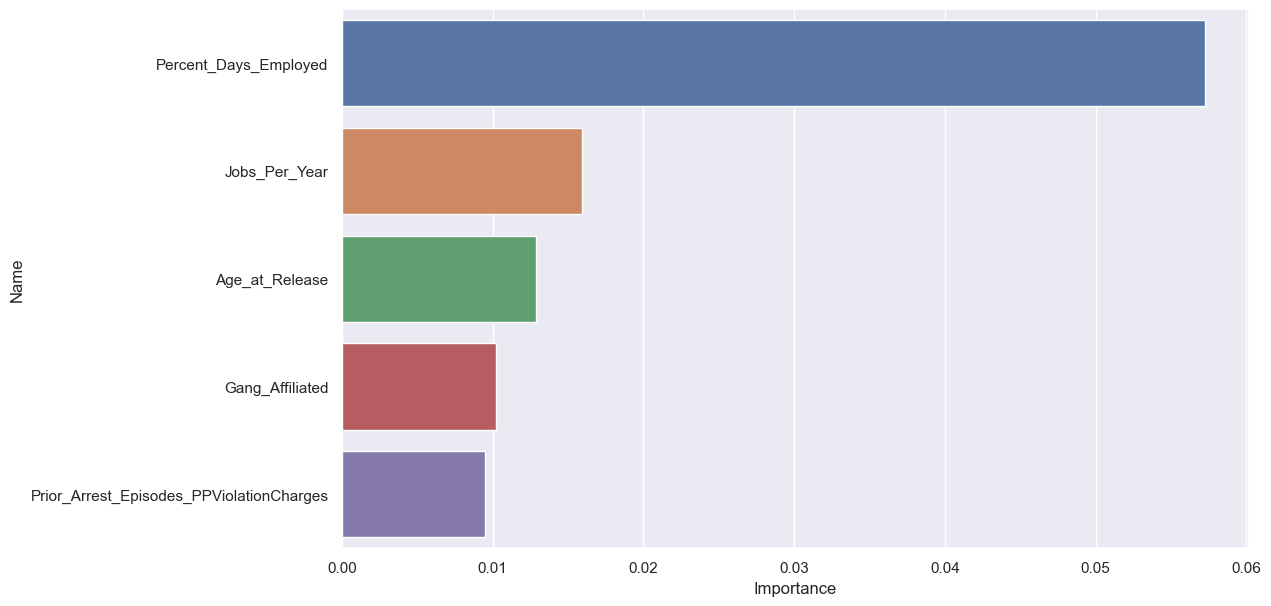

In [67]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now, use Permutation Feature Importance on SVM and XGBoost.

**Hint:** these are more complex models; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### SVM Model:

In [68]:
out_svm = permutation_importance(svm_model, X_test, y_test, n_repeats=2, random_state=0)

<Axes: xlabel='Importance', ylabel='Name'>

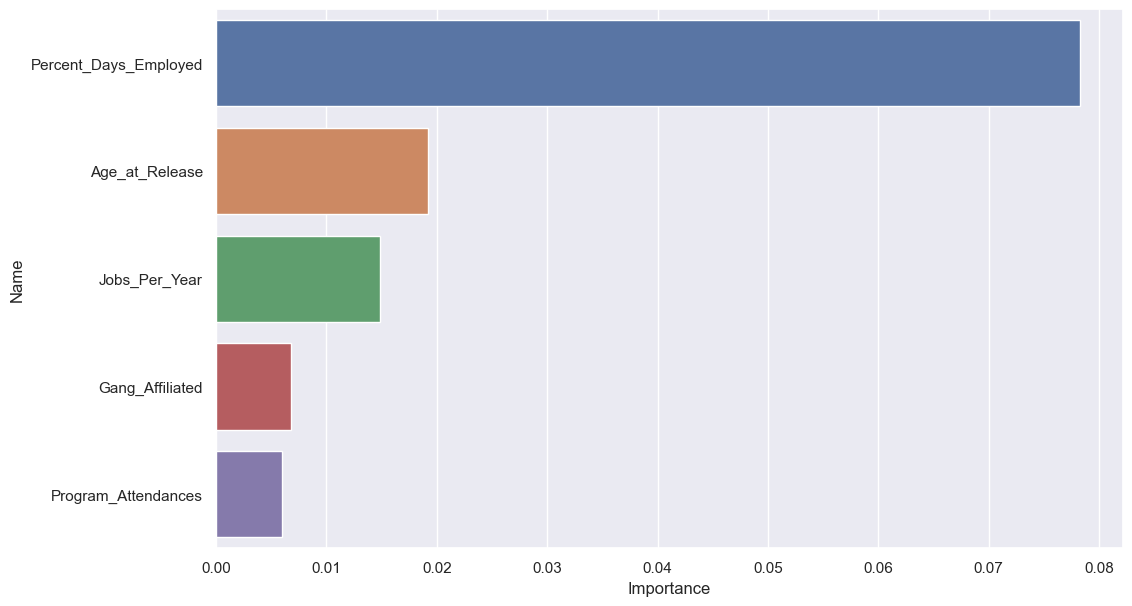

In [69]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out_svm["importances_mean"], "STD": out_svm["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

#### XGBoost Model:

In [70]:
out_xgb = permutation_importance(xgboost_model, X_test, y_test, n_repeats=2, random_state=0)

<Axes: xlabel='Importance', ylabel='Name'>

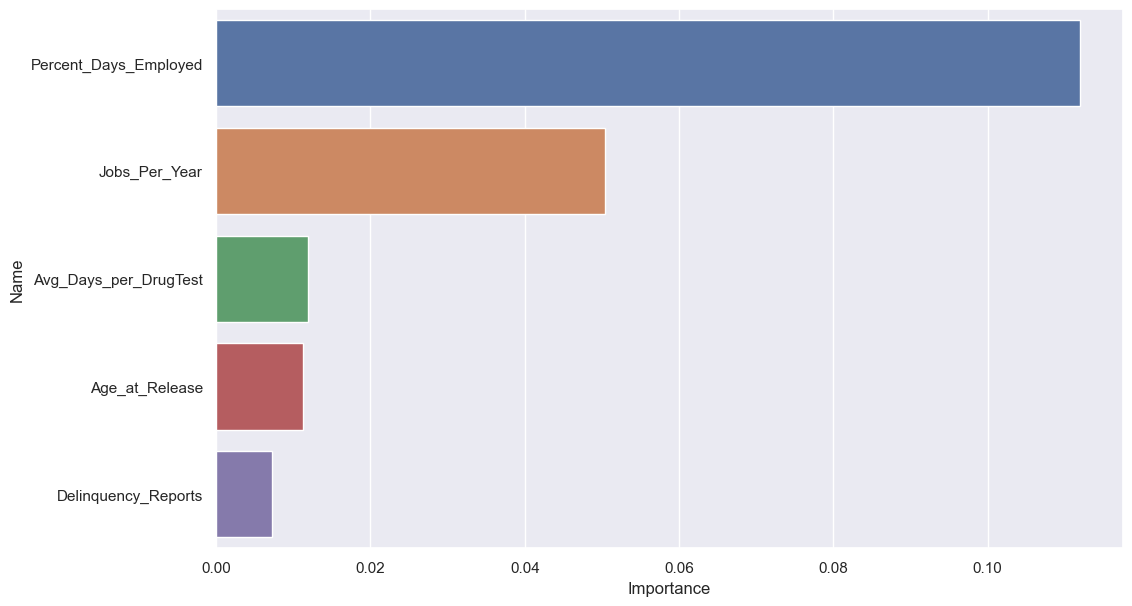

In [71]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out_xgb["importances_mean"], "STD": out_xgb["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

The Random Forest model selected Percent Days Employed, Jobs Per Year, Age at Release, Gang Affilated as the most important features; The SVM model selected Percent_Days_Employed, Age_at_Release, Jobs_Per_Year, Gang_Affiliated, Program_Attendances as the most important features; the XG boost model selected Percent_Days_Employed, Age_at_Release, Jobs_Per_Year, Gang_Affiliated, and Delinquency_Reports. All three models ranks  "Percent_Days_Employed" as the most influential feature. The three models select features that mostly align with each other, which shows reliability. However, this result is not similar to what we observed in the surrogate model. In the surrogate model all models ranks age_at_release as the most imfluential feature, which is inconsistent with our permutation Feature Importance analysis. This might imply that the surrogation models are not accurately enough to capture the same predictions as the original model.

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [72]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [73]:
import shap # downgrade numpy to version = 1.23
shap.initjs()

SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [74]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 106) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [75]:
rf_explainer = shap.Explainer(rf_model[-1])  # creating SHAP Explainer based on the model

rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

This gives us the SHAP values for each sample and each feature (the index 1 indicates the positive class):

In [76]:
rf_shap_values[1]

array([[ 3.91335950e-03, -9.62851015e-03,  3.92466073e-03, ...,
         8.59832423e-03,  2.28056047e-03, -4.24814777e-03],
       [ 2.22170734e-04,  2.87915447e-02, -3.57537858e-03, ...,
        -4.06188605e-04,  6.69732024e-03, -5.14016102e-05],
       [ 5.19046262e-03,  4.10504827e-02, -3.31137285e-03, ...,
         1.07981182e-04,  5.36841724e-04,  1.24264732e-03],
       ...,
       [-1.09513268e-02,  2.74767739e-02,  1.91833769e-03, ...,
         1.20264140e-02,  3.10544328e-04,  2.01321757e-03],
       [ 3.95959127e-03,  3.37735544e-02, -3.14675700e-02, ...,
        -9.27747240e-04,  7.98518224e-05, -2.45657378e-04],
       [-3.94334448e-03,  8.21011060e-03, -4.81923980e-03, ...,
        -7.63568655e-04,  3.85609483e-04,  3.01598369e-03]])

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [77]:
values = np.abs(rf_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.071417
pipeline-2__Gang_Affiliated_True,0.029298
pipeline-1__Supervision_Risk_Score_First,0.025345
pipeline-1__DrugTests_THC_Positive,0.023308
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,0.020529
pipeline-1__Jobs_Per_Year,0.020520
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,0.016601
pipeline-2__Age_at_Release_48 or older,0.015831
pipeline-2__Prior_Conviction_Episodes_Misd_0,0.013032
pipeline-1__DrugTests_Meth_Positive,0.012359


The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

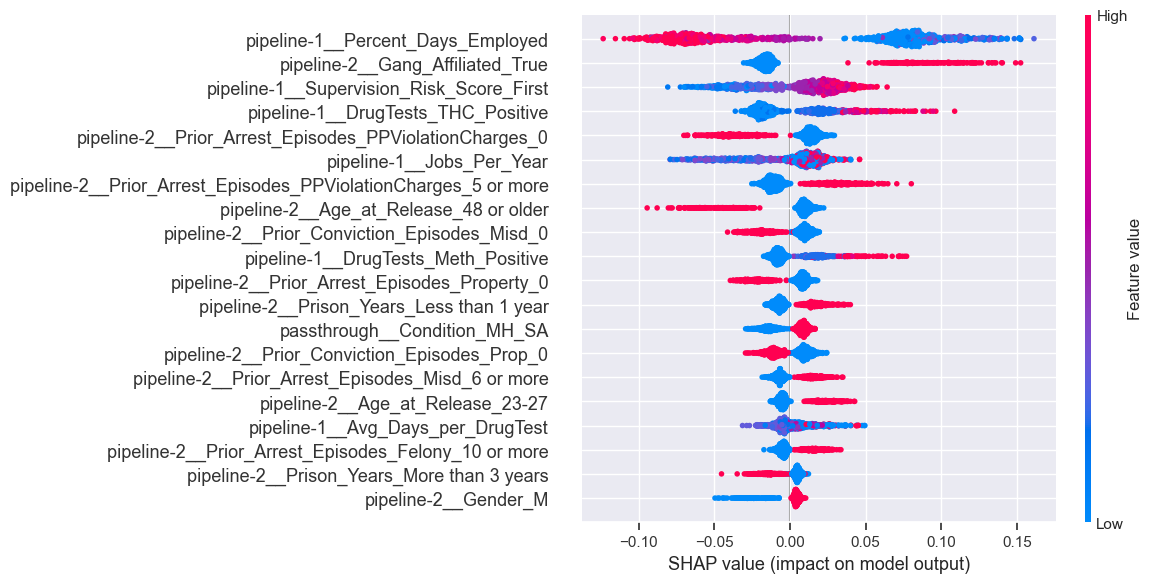

In [78]:
shap_figure = shap.summary_plot(rf_shap_values[1], X_test_enc.iloc[ind], plot_size=[12,6])

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.


The SHAP value for a feature and a particular prediction explains how much knowing that feature's value changes the output of the model for that prediction.
 
For high SHAP values of a feature:
 
A high positive SHAP value indicates that the feature value for a particular instance has a high positive impact on the model's prediction. In other words, if the feature's actual value for an instance is high, the model is more likely to predict a positive outcome (e.g., higher risk of recidivism). On the other hand, a high negative SHAP value indicates that the feature value for an instance has a high negative impact on the model's prediction. If the actual feature value is high in this case, it decreases the likelihood of a positive outcome.
 
For low SHAP values of a feature:
A low SHAP value, close to zero, implies that the feature value for that instance does not sway the model's output much one way or the other. It means the feature is less important for that particular prediction.
 
Looking at the plot above:
'Percent Days Employed': High SHAP value suggest that when this feature has a high value, it significantly decreases the model's output, thus lowering the probability of recidivism. This is a strong indicator that employment is an important factor in reducing recidivism risk.
'Gang Affiliation': High positive SHAP values here mean that being affiliated with a gang (a high feature value) increases the predicted probability of recidivism.
'Supervision Risk Score First': This feature seems to have both high positive and negative SHAP values, so depending on the value, it can either increase or decrease the probability of recidivism. Higher values of this feature increase recidivism risk, while lower values decreases.
‘Drug Tests (THC Positive)’: Positive SHAP values indicate that positive THC drug tests contribute to a higher prediction of recidivism.
‘Jobs Per Year’: The distribution of SHAP values here is mixed, indicating that the number of jobs per year may both increase and decrease the risk of recidivism, depending on the individual case.

Comparing SHAP to surrogate models:
Surrogate models, like logistic regression, can assign fixed coefficients to features regardless of the scale of the feature value. For instance, the variable "Age at Release" might show a positive number, but it does not convey by how much the prediction changes with age - it only indicates the direction of the relationship. SHAP values, on the other hand, capture the alteration in prediction for each increment or decrement in "Age at Release."
SHAP values offer a more detailed outlook by demonstrating how diverse feature values influence predictions. For example, though logistic regression may indicate that "Age at Release" is a significant factor, SHAP values can reveal if lower or higher ages are more indicative of recidivism danger.
Consistency in the predictive power of "Gang Affiliation" throughout various models shows its reliability.
In short, SHAP values provide a thorough picture of the impact of the feature value. This allows for a more specific understanding compared to conventional techniques, which may not entirely comprehend the correlations between feature values and the prediction.


Next, **repeat this analysis for SVM and XGBoost.**

In [79]:
X_train_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=xgboost_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  

ind = np.append(ind, 106) 

xgb_explainer = shap.Explainer(xgboost_model[-1])  
xgb_shap_values = xgb_explainer.shap_values(X_test_enc.iloc[ind])

xgb_shap_values[1]

array([ 4.11427952e-02,  9.98056605e-02, -1.70926541e-01,  1.24462023e-01,
       -1.40986871e-02, -7.57222548e-02,  8.84357840e-03,  1.01178396e+00,
       -3.97979409e-01,  6.70271739e-02, -2.23288015e-02, -4.15815152e-02,
       -5.87986484e-02,  9.34392437e-02,  4.72738966e-03,  1.28934542e-02,
        2.60179210e-02,  5.01691513e-02, -1.03209563e-01, -3.50358477e-03,
        1.71749778e-02,  2.51302272e-02, -2.28692535e-02, -3.39634679e-02,
       -2.35181046e-03,  2.00643931e-02, -1.08005814e-02, -3.53142899e-03,
       -2.71155834e-02,  1.25529729e-02,  1.40718883e-03, -4.12518485e-03,
       -7.22541520e-03,  5.51651884e-03, -6.51235739e-03, -2.72159845e-01,
       -3.97770107e-02,  3.99814844e-02, -7.39488285e-04,  2.04400495e-02,
        1.25064448e-01,  4.66787722e-03,  8.78781825e-03,  2.21573282e-03,
        4.95787757e-03, -7.18882680e-03,  5.47527568e-03, -3.69536015e-03,
       -2.33726064e-03,  3.40021551e-02,  5.93121536e-03,  5.74058155e-03,
        1.79561772e-04, -

In [80]:
values = np.abs(xgb_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
pipeline-1__Residence_PUMA,0.044191
pipeline-2__Prior_Conviction_Episodes_Misd_2,0.044191
pipeline-2__Delinquency_Reports_4 or more,0.044191
pipeline-2__Delinquency_Reports_3,0.044191
pipeline-2__Delinquency_Reports_2,0.044191
pipeline-2__Delinquency_Reports_1,0.044191
pipeline-2__Delinquency_Reports_0,0.044191
pipeline-2__Prior_Conviction_Episodes_Drug_2 or more,0.044191
pipeline-2__Prior_Conviction_Episodes_Drug_1,0.044191
pipeline-2__Prior_Conviction_Episodes_Drug_0,0.044191


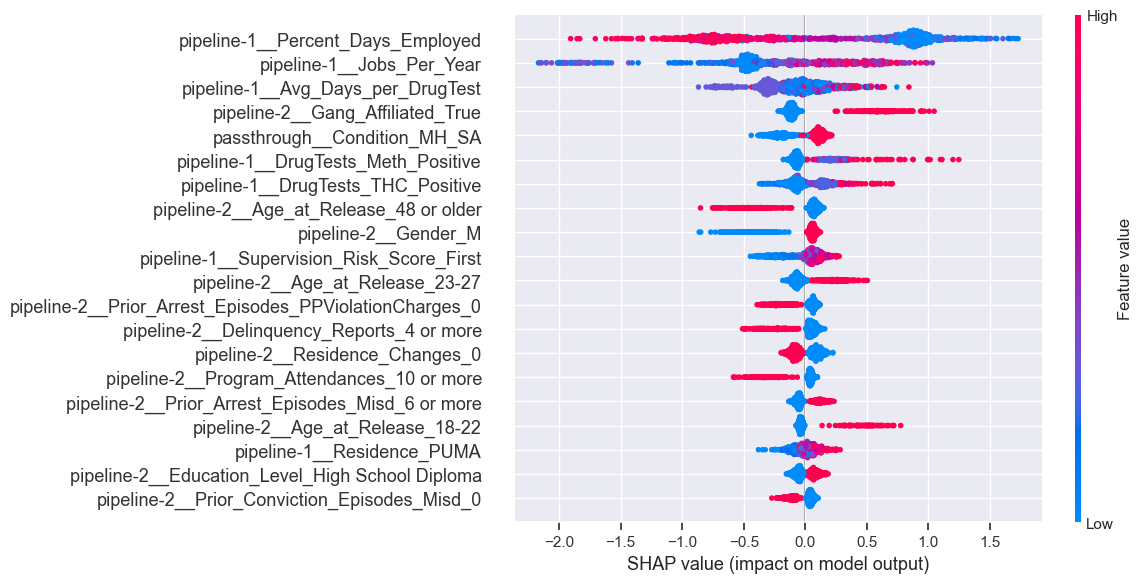

In [81]:
shap_figure = shap.summary_plot(xgb_shap_values, X_test_enc.iloc[ind], plot_size=[12,6])

Looking the plot above, high values of a feature (in red) pushing the prediction higher and low values (in blue) driving it lower can be discerned. The SHAP plot illustrates that features like pipeline-1__DrugTests_Meth_Positive and pipeline-2__Gang_Affiliated_True increase the model's output, while pipeline-2__Age_at_Release_48 or older and pipeline-2__Gender_M` decrease it. The color intensity indicates feature value magnitude, with red showing high and blue showing low values.In contrast, the Permutation Feature Importance bar chart simplifies the feature impacts into average effects across all predictions, losing the individual detail but offering an easy-to-interpret ranking of feature importance. 

When comparing the SHAP results with the surrogate model's top and bottom coefficients, there is a direct comparison to be made. The surrogate model's coefficients imply a linear relationship between the features and the prediction, providing a single average effect size for each feature. For instance, pipeline-2__Age_at_Release_18-22 has a large positive coefficient in the surrogate model, indicating a strong average increase in the prediction when this feature is present. However, this averaged view might not capture the full complexity of the model's use of that feature across all predictions as SHAP does. Similarly, features like pipeline-1__Percent_Days_Employed show significant negative coefficients, suggesting a strong average decrease in the prediction, which might be a general trend but does not account for the nuance in individual predictions that SHAP values offer.

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

In [82]:
hard_sample_prediction = rf_model.predict(hard_sample)

true_label = y_test[106]

is_correct = hard_sample_prediction[0] == true_label

print(f"Random Forest Prediction for Hard Sample: {hard_sample_prediction[0]}")
print(f"True Label: {true_label}")
print(f"Is the prediction correct? {'Yes' if is_correct else 'No'}")

Random Forest Prediction for Hard Sample: True
True Label: False
Is the prediction correct? No


Let's look at the **force plot** for this particular prediction, by running the cell below:

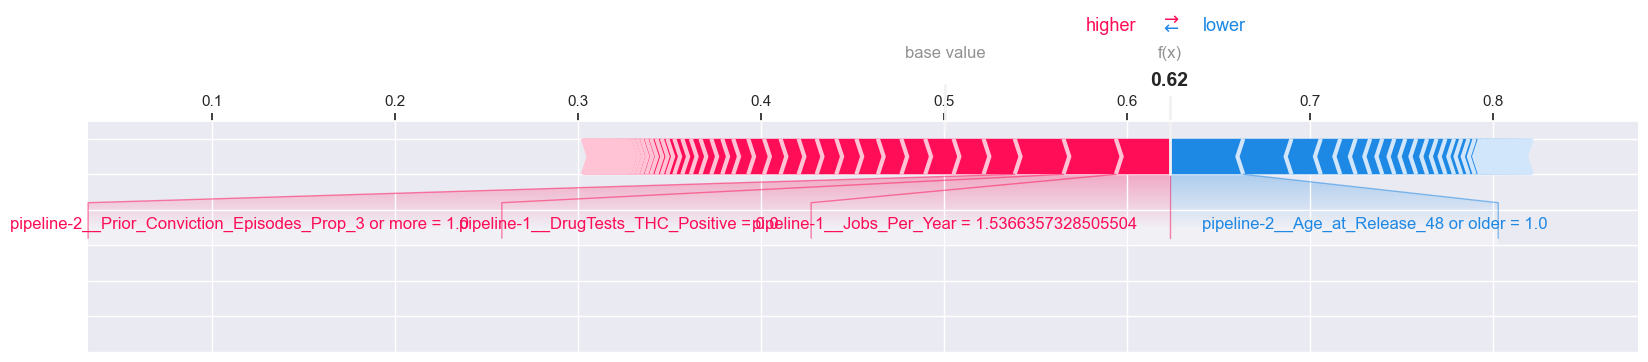

In [83]:
shap.force_plot(
    rf_explainer.expected_value[1],
    rf_shap_values[1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

1. What contributed the most to the prediction?

    The red features are pushing the model's prediction higher than the base value. The more to the right a feature is, the more it contributes to increasing the prediction. From the plot, we can see that the most significant positive contributor is pipeline-2__Prior_Conviction_Episodes_Prop_3 or more = 1. This means that having 3 or more prior conviction episodes significantly increased the prediction value.

2. What countered the prediction the most?

    The blue features are pushing the model's prediction lower than the base value. The more to the left a feature is, the more it contributes to decreasing the prediction. From the plot, we can see the most significant negative contributor is pipeline-2__Age_at_Release_48 or older = 1.0. This indicates that being 48 years or older at the time of release decreases the prediction value the most among all considered features.

3. Can we tell, by looking at the plot, that this was a difficult prediction?

    Yes, we can make some observations to determine if this was a difficult prediction. The final output prediction (f(x)) is 0.62, which is relatively close to the mid-point (0.5). The closer a prediction is to the midpoint, the harder it generally is for the model to make a confident binary classification. There's a tug-of-war between the red (positive) and blue (negative) features. When both positive and negative SHAP values have strong magnitudes and are pulling the prediction in opposite directions, it indicates that there are conflicting signals in the data for the sample. This indicates the prediction's difficulty.

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by SVM, XGBoost and Decision Tree** (since we were not able to do the latter earlier).

In [84]:
hard_sample_prediction = xgboost_model.predict(hard_sample)

true_label = y_test[106]

is_correct = hard_sample_prediction[0] == true_label

print(f"XGBoost Model Prediction for Hard Sample: {hard_sample_prediction[0]}")
print(f"True Label: {true_label}")
print(f"Is the prediction correct? {'Yes' if is_correct else 'No'}")

XGBoost Model Prediction for Hard Sample: 1
True Label: False
Is the prediction correct? No


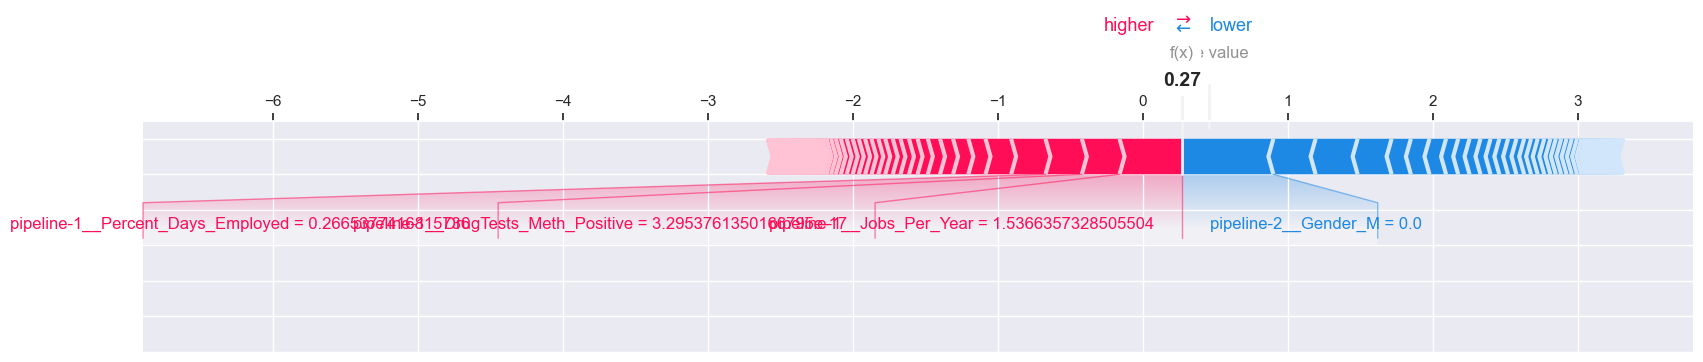

In [85]:
shap.force_plot(
    xgb_explainer.expected_value,
    xgb_shap_values[-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

1. What contributed the most to the prediction?

The feature that contributes the most to increasing the prediction value is shown in red and extends farthest to the right. In this case, the feature is pipeline-1__Drug_Tests_Meth_Positive = 3.295376135016292e-11, which indicates that having a positive methamphetamine drug test is the strongest driver increasing the model's prediction score.

2. What countered the prediction the most?

The features that decrease the prediction value are shown in blue and extend to the left. The feature that most significantly decreases the prediction value is pipeline-2__Gender_M = 0.0, suggesting that the individual's gender being male has the strongest negative impact on the prediction value.

3. Can we tell, by looking at the plot, that this was a difficult prediction?

The prediction value (f(x)) is 0.27, which is closer to the base value of 0.0 than to 1.0. This indicates that the model's output for this particular instance leans towards a certain class but is not overly confident. The length and direction of the feature impact bars suggest that there is a mix of both strong positive and negative influences on the prediction. The fact that the final prediction value is not near the extremes (0 or 1) and that there is a significant counter (blue feature) to the largest contributing factor (red feature) could suggest that the model faced some level of difficulty in making a clear-cut decision for this instance.

In [86]:
hard_sample_prediction = tree_model.predict(hard_sample)

true_label = y_test[106]

is_correct = hard_sample_prediction[0] == true_label

print(f"Decision Tree Model Prediction for Hard Sample: {hard_sample_prediction[0]}")
print(f"True Label: {true_label}")
print(f"Is the prediction correct? {'Yes' if is_correct else 'No'}")

Decision Tree Model Prediction for Hard Sample: True
True Label: False
Is the prediction correct? No


In [87]:
X_train_enc = pd.DataFrame(
    data=tree_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=tree_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  

ind = np.append(ind, 106) 

tree_explainer = shap.Explainer(tree_model[-1])  
tree_shap_values = tree_explainer.shap_values(X_test_enc.iloc[ind])

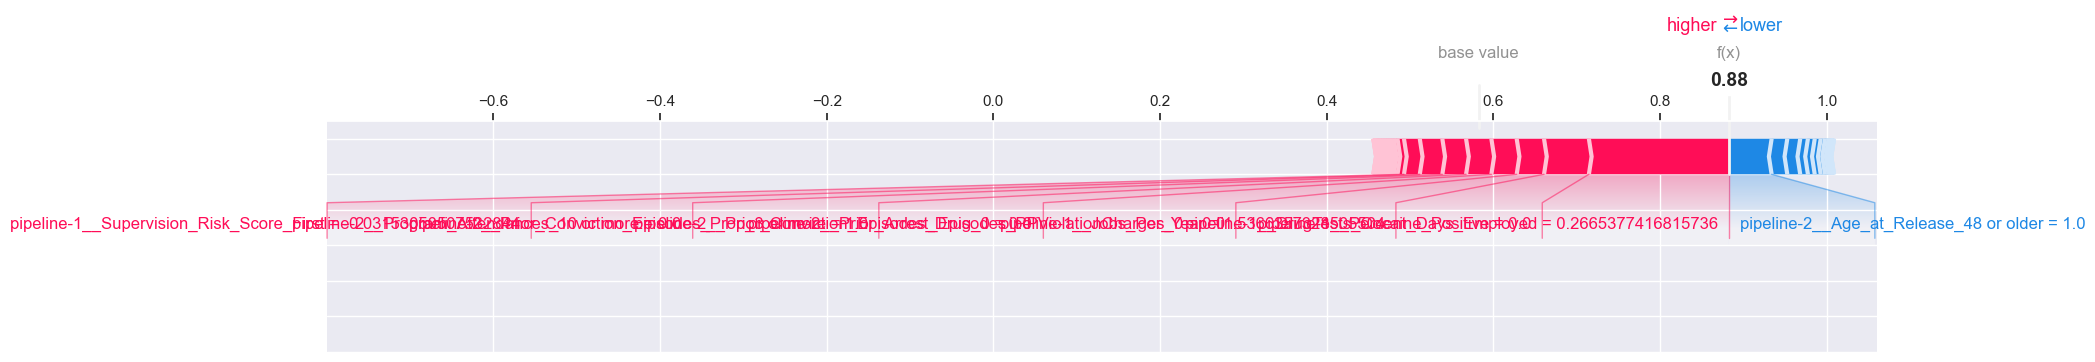

In [88]:
shap.force_plot(
    tree_explainer.expected_value[1],
    tree_shap_values[1][-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

1. What contributed the most to the prediction?

The most significant contribution to increasing the prediction value is from the red feature on the far right. It's labeled as pipeline-1__Supervision_Risk_Score_First_to_Current = 1, which implies that the first to current supervision risk score being categorized as '1' has the largest positive effect on the prediction, pushing it towards the higher end of the scale.

2. What countered the prediction the most?

The blue feature on the far left is the most significant in countering the prediction, which is pipeline-2__Age_at_Release_48 or older = 1.0. Just like in the previous plot, this indicates that being 48 years or older at the time of release is the factor that most significantly decreases the prediction value, although in this case, it was not strong enough to bring the prediction close to or below the threshold.

3. Can we tell, by looking at the plot, that this was a difficult prediction?

The prediction does not appear to have been difficult for the model given that the final prediction value is quite high at 0.88. This suggests that the model had a high level of confidence in its prediction. The presence of both red and blue features does indicate that there were both positive and negative contributions to the prediction. However, the positive contributions were significantly stronger, leading to a high prediction value. There's less of a 'tug-of-war' compared to the previous plot, suggesting that the features that contributed to the prediction aligned more uniformly in one direction.

# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 models, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

With this thorough analysis that we've performed in this assignment, I would choose to deploy the XG Boost model. It has the highest test accuracy, precision, AUC, and high recall. The high AUC indicates it performs well in distinguishing between the classes.In addtion, the surrogate model for the svm model it has a highest count r2 score of 0.94, which implies the surrogate SVM model seems to be more reliable in terms of capturing the variance of the black box version. The permutation feature importance analysis also shows that XG Boost's selection of features aligns with that of the SVM model, which implies that its predictions are very reliable.
The only weakness of the SVM model is that it did not perform as well in the fairness evaluation. However, for the purpose of this task, we do not want to release the people with the risk to commit crimes again, and we would want to favor reporting the most number of positives for all the true positives at the tradeoff of reporting false positives, because not releasing a former criminal would do less societal harm than releasing a former criminal to commit another crime. So I think this is an acceptable tradeoff.

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

We discussed and brainstormed each of the questions, and then divided up the work to finish them individually.

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

We asked ChatGPT to explain the unfamiliar concepts for us.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

We are unsure about our coding part.